In [1]:
import fasttext
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import os
import random
from itertools import combinations, product
from tqdm import tqdm
import matplotlib.pyplot as plt
import time

import tensorflow as tf
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Input, Dropout, Lambda, Concatenate, GRU
from tensorflow.keras.regularizers import l2

# Have to download the stopwords
# nltk.download('stopwords')

In [2]:
# Get the fasttext model (we are using the largest one they offer [600B tokens])
fasttext_model = fasttext.load_model('models/crawl-300d-2M-subword.bin')

## General Useful Function
Functions that are continually used throughout this project

In [2]:
"""
Definitions of some sizes in the training set
"""
MAX_LEN = 45
EMBEDDING_SHAPE = (300,)
print('MAX_LEN: ' + str(MAX_LEN), 'EMBEDDING_SHAPE: ' + str(EMBEDDING_SHAPE))

MAX_LEN: 45 EMBEDDING_SHAPE: (300,)


In [3]:
def get_max_len(df):
    max_len = 0
    for row in df.itertuples():
        if len(row.title_one.split(' ')) > max_len:
            max_len = len(row.title_one.split(' '))
            
        if len(row.title_two.split(' ')) > max_len:
            max_len = len(row.title_two.split(' '))
    
    return max_len

In [4]:
def print_dataframe(df):
    for idx in range(len(df)):
        print(df.iloc[idx].title_one + '\n' + df.iloc[idx].title_two)
        print('________________________________________________________________')

In [5]:
def create_final_data(pos_df, neg_df):
    pos_df = pos_df.sample(frac=1)
    neg_df = neg_df.sample(frac=1)
    final_df = pd.concat([pos_df[:min(len(pos_df), len(neg_df))], neg_df[:min(len(pos_df), len(neg_df))]])
    final_df = final_df.sample(frac=1)
    return final_df

In [6]:
def remove_stop_words(phrase):
    # Creates the stopwords
    to_stop = stopwords.words('english')
    to_stop.remove('m')
    punctuation = "!”#$%&’()*+,-./:;<=>?@[\]^_`{|}~ \""
    for c in punctuation:
        to_stop.append(c)

    to_stop.append('null')
    
    for punc in punctuation:
        phrase = phrase.replace(punc, ' ')
    
    return ' '.join((' '.join([x for x in phrase.split(' ') if x not in to_stop])).split()).lower()


In [7]:
# Drop the Unnamed: 0 column and drop any row where it is all NaN
def remove_misc(df):
    columns = list(df.columns)[1:]
    df = df.drop(columns=['Unnamed: 0'])
    df = df.dropna(how='all')
    return df


## Data Processsing and Organization
Here, all we really want to do is prepare the data for training. This is **only** the data from **Gold Standard** This includes:
* Simplifying the original data
* Normalizing the data 
* Balancing the positive and negative examples
* Creating the embedding representations that will actually get fed into the neural network

In [153]:
# Organizing and normalizing the data
"""
Essentially, we want to only have three attributes for each training example: title_one, title_two, label
For normalization, we are just going to use the nltk stopwords and punctuation
"""

def preprocessing(orig_data):
    """
    Normalizes the data by getting rid of stopwords and punctuation
    """
    
    # The new names of the columns
    column_names = ['title_one', 'title_two', 'label']
    # A new dataframe for the data we are going to be creating
    norm_data = pd.DataFrame(columns = column_names)
    # Iterate over the original dataframe (I know it is slow and there are probably better ways to do it)
    iloc_data = orig_data.iloc
    for idx in tqdm(range(len(orig_data))):
        row = iloc_data[idx]
        title_left = remove_stop_words(row.title_left)
        title_right = remove_stop_words(row.title_right)
        
        # Append the newly created row (title_left, title_right, label) to the new dataframe
        norm_data = norm_data.append(pd.DataFrame([[title_left, title_right, row.label]], columns=column_names))
    
    return norm_data
        

In [154]:
def create_train_df(df):
    """
    Returns a shuffled dataframe with an equal amount of positive and negative examples
    """
    # Get the positive and negative examples
    pos_df = df.loc[df['label'] == 1]
    neg_df = df.loc[df['label'] == 0]
    
    # Shuffle the data
    pos_df = pos_df.sample(frac=1)
    neg_df = neg_df.sample(frac=1)
    
    # Concatenate the positive and negative examples and 
    # make sure there are only as many negative examples as positive examples
    final_df = pd.concat([pos_df[:min(len(pos_df), len(neg_df))], neg_df[:min(len(pos_df), len(neg_df))]])
    
    # Shuffle the final data once again
    final_df.sample(frac=1)
    
    return final_df

In [155]:
def create_training_data(df, path):
    """
    Creates and saves a simpler version of the original data that only contains the the two titles and the label.
    """
    
    norm_bal_data = create_train_df(preprocessing(df))
    
    # Save the new normalized and simplified data to a CSV file to load later
    norm_bal_data.to_csv(path, index=False)

In [156]:
# Load the data
computer_df = pd.read_json('data/train/computers_train_xlarge_normalized.json.gz', compression='gzip', lines=True)

In [157]:
# See some of the data. There is clearly a separation between the positive and negative examples
computer_df

,id_left,title_left,description_left,brand_left,price_left,specTableContent_left,keyValuePairs_left,category_left,cluster_id_left,identifiers_left,...,description_right,brand_right,price_right,specTableContent_right,keyValuePairs_right,category_right,cluster_id_right,identifiers_right,label,pair_id
0,5490217,hp intel xeon x5560 prijzen tweakers,None,None,None,categorie processors merk hp product hp intel ...,"{'categorie': 'processors', 'merk': 'hp', 'pro...",Computers_and_Accessories,1679624,"[{'/mpn': '[495906b21]'}, {'/gtin13': '[884420...",...,description intel xeon x5560 ml350 g6 2 80ghz ...,hp enterprise,usd 213 85,specifications category proliant processor sub...,"{'category': 'proliant processor', 'sub catego...",Computers_and_Accessories,1679624,[{'/mpn': '[495906b21]'}],1,5490217#16248399
1,16876009,"495906 b21 hp x5560 2 80ghz ml350 g6 , null ne...",description intel xeon x5560 ml350 g6 2 80ghz ...,hp enterprise,None,specifications category proliant processor sub...,"{'category': 'proliant processor', 'sub catego...",Computers_and_Accessories,1679624,"[{'/sku': '[495906b21]'}, {'/mpn': '[495906b21...",...,description intel xeon x5560 ml350 g6 2 80ghz ...,hp enterprise,usd 213 85,specifications category proliant processor sub...,"{'category': 'proliant processor', 'sub catego...",Computers_and_Accessories,1679624,[{'/mpn': '[495906b21]'}],1,16876009#16248399
2,16543750,asus motherboard lga2066 ddr4 m 2 u atx 2xgbe ...,None,None,None,None,None,Computers_and_Accessories,109916,"[{'/sku': '[34181655]'}, {'/mpn': '[primex299d...",...,placa base atx socket lga2066 chipset intel x2...,None,None,None,None,Computers_and_Accessories,109916,[{'/productID': '[90mb0ty0m0eay0]'}],1,16543750#14031864
3,16721450,asus prime x299 deluxe prijzen tweakers,None,None,None,categorie moederborden merk asus product asus ...,"{'categorie': 'moederborden', 'merk': 'asus', ...",Computers_and_Accessories,109916,"[{'/mpn': '[primex299deluxe, 90mb0ty0m0eay0]'...",...,support for x series intel core processors sli...,asus,None,None,None,Computers_and_Accessories,109916,"[{'/mpn': '[90mb0ty0m0eay0]'}, {'/gtin13': '[4...",1,16721450#10358026
4,14031864,asus prime x299 deluxe,placa base atx socket lga2066 chipset intel x2...,None,None,None,None,Computers_and_Accessories,109916,[{'/productID': '[90mb0ty0m0eay0]'}],...,atx quad channel ddr4 3 x pcie 3 0 x16 2 x m 2...,asus,None,None,None,Computers_and_Accessories,109916,"[{'/productID': '[asux29del]'}, {'/mpn': '[pri...",1,14031864#4588573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68456,11523636,seagate barracuda es 2 st3750330ns 750gb 3 5 h...,None,seagate,None,None,None,Computers_and_Accessories,987859,[{'/mpn': '[st3750330ns]'}],...,description 10 x 500gb hot plug serial ata sat...,hp enterprise,None,specifications category proliant harddrive sub...,"{'category': 'proliant harddrive', 'sub catego...",Computers_and_Accessories,2516582,"[{'/sku': '[45414100210pack]'}, {'/mpn': '[454...",0,11523636#13889537
68457,16852097,seagate barracuda es 2 750gb sata ii 32mb cach...,750gb capacity sata ii interface 7200rpm spin ...,seagate,None,None,None,Computers_and_Accessories,987859,[{'/mpn': '[st3750330ns]'}],...,description hp 6tb 3 5 inch lff serial attache...,hp enterprise,None,specifications category proliant harddrive sub...,"{'category': 'proliant harddrive', 'sub catego...",Computers_and_Accessories,12211572,"[{'/sku': '[782995001]'}, {'/mpn': '[782995001...",0,16852097#16101389
68458,11002668,"null , st3750330ns seagate 750 gb 15k 3 5 3g sata",description 2 x seagate barracuda 750gb non ho...,seagate,cad 298 87 cad,specifications category seagate harddrive sub ...,"{'category': 'seagate harddrive', 'sub categor...",Computers_and_Accessories,987859,[{'/mpn': '[st3750330ns]'}],...,the one drive for every desktop system need su...,seagate,us 46 99,official release date sep 30 2011 genre hard d...,"{'official release date': 'sep 30 2011', 'genr...",Computers_a

In [158]:
# Create and save the data if the simple and normalized data does not exist
computer_data_path = 'data/train/computers_train_bal_shuffle.csv'

# If the computer data has not been made yet, make it
if not os.path.exists(computer_data_path):
    create_training_data(computer_df, computer_data_path)

100%|██████████| 68461/68461 [07:42<00:00, 147.91it/s]


In [ ]:
# Load cameras data
camera_df = pd.read_json('data/train/cameras_train_xlarge_normalized.json.gz', compression='gzip', lines=True)

In [ ]:
camera_df

In [ ]:
# Create and save the data if the simple and normalized data does not exist
camera_data_path = 'data/train/cameras_train_bal_shuffle.csv'

# If the computer data has not been made yet, make it
if not os.path.exists(camera_data_path):
    create_training_data(camera_df, camera_data_path)

In [7]:
final_computer_df = pd.read_csv('data/train/computers_train_bal_shuffle.csv')

In [88]:
final_computer_df = final_computer_df.sample(frac=1)

In [89]:
final_computer_df

,title_one,title_two,label
14087,crucial 4gb pc3 12800 204 pin ddr3 sdram sodim...,ddr3 kingston value 8go 1600 mhz 2x4,0
2561,amd ryzen 5 1600x boxed zonder koeler prijzen ...,amd ryzen 5 1600x six core processor without c...,1
7111,amd athlon x4 860k 3 7 ghz black low noise edi...,amd athlon x4 860k 3 7ghz quad core processor ...,1
14074,fire tablet 7 display wi fi 8 gb includes spec...,amazon fire hd 8 16gb 6th gen 2016 release black,0
2699,hp 300876 b21 proliant bl20p g2,300876 b21 bl20p g2 xeon 2 8ghz 512 1p,1
...,...,...,...
4455,16gb 2133mh ddr4cl14 dimm furyblack tradineur com,kingston hyperx fury black hx421c14fb2k2 16 pr...,1
7304,432094 b21 hp 146 gb 15k 3 5 sp sas 2 pack par...,432094 b21 hp 146 gb 15k 3 5 sp sas new pack w...,1
15357,gigabyte z370m d3h intel z370 socket 1151 ddr4...,asus prime b250m plus intel b250 socket 1151 d...,0
18292,dell ultrasharp u2414h 23 8 full hd ips monito...,kingston valueram ddr4 16 gb 2 x 8 dimm 288 pi...,0


In [ ]:
final_camera_df = pd.read_csv('data/train/cameras_train_bal_shuffle.csv')

In [ ]:
final_camera_df

## Laptop Data Preprocessing
* Normalize the data
* Create negative examples that represent when only a couple of attributes of the laptop data changes

In [198]:
# Load the laptop data
laptop_df = pd.read_csv('data/train/laptops.csv', encoding='latin-1')

In [199]:
laptop_df

,Unnamed: 0,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00
3,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
4,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1298,1316,Lenovo,Yoga 500-14ISK,2 in 1 Convertible,14.0,IPS Panel Full HD / Touchscreen 1920x1080,Intel Core i7 6500U 2.5GHz,4GB,128GB SSD,Intel HD Graphics 520,Windows 10,1.8kg,638.00
1299,1317,Lenovo,Yoga 900-13ISK,2 in 1 Convertible,13.3,IPS Panel Quad HD+ / Touchscreen 3200x1800,Intel Core i7 6500U 2.5GHz,16GB,512GB SSD,Intel HD Graphics 520,Windows 10,1.3kg,1499.00
1300,1318,Lenovo,IdeaPad 100S-14IBR,Notebook,14.0,1366x768,Intel Celeron Dual Core N3050 1.6GHz,2GB,64GB Flash Storage,Intel HD Graphics,Windows 10,1.5kg,229.00
1301,1319,HP,15-AC110nv (i7-6500U/6GB/1TB/Radeon,Notebook,15.6,1366x768,Intel Core i7 6500U 2.5GHz,6GB,1TB HDD,AMD Radeon R5 M330,Windows 10,2.19kg,764.00


In [200]:
# This class will be used in order to exchange the different attributes
# to create negative examples
class LaptopAttributes():
    company = {'Apple'}
    product = {'MacBook Pro'}
    inches = {'13.3'}
    cpu = {'Intel Core i5 2.3GHz'}
    ram = {'4GB'}
    memory = {'256GB SSD'}
    gpu = {'Intel HD Graphics 520'}
    screen = {'1440x900'}
    
    def get_all_data():
        return {
            'company': LaptopAttributes.company,
            'product': LaptopAttributes.product,
            'inches': LaptopAttributes.inches,
            'cpu': LaptopAttributes.cpu,
            'ram': LaptopAttributes.ram,
            'memory': LaptopAttributes.memory,
            'gpu': LaptopAttributes.gpu,
            'screen': LaptopAttributes.screen
        }

In [201]:
# Create attribute sets
def create_attribute_sets(df):
    LaptopAttributes.company.update([row.Company for row in laptop_df[['Company']].itertuples()])
    LaptopAttributes.product.update([row.Product for row in laptop_df[['Product']].itertuples()])
    LaptopAttributes.inches.update([str(row.Inches) for row in laptop_df[['Inches']].itertuples()])
    LaptopAttributes.cpu.update([row.Cpu for row in laptop_df[['Cpu']].itertuples()])
    LaptopAttributes.ram.update([row.Ram for row in laptop_df[['Ram']].itertuples()])
    LaptopAttributes.memory.update([row.Memory for row in laptop_df[['Memory']].itertuples()])
    LaptopAttributes.gpu.update([row.Gpu for row in laptop_df[['Gpu']].itertuples()])
    LaptopAttributes.screen.update([row.ScreenResolution for row in laptop_df[['ScreenResolution']].itertuples()])

create_attribute_sets(laptop_df)

In [202]:
def concatenate_row(row):
    # Note: got rid of everything after the '(' because it has info about the actual specs of the laptop
    # so if we change the specs, we need to fix that too
    
    # Special tags at the end of the amount of inches of the laptop and the RAM to simulate real data
    inch_attr = str(row['Inches']) + random.choice([' inch', '', '"'])
    ram_attr = row['Ram'] + random.choice([' ram', ' memory', ''])
    
    # These are words that commonly come up with laptops
    modifiers = ['premium', 'new', 'fast', 'latest model']
    add_ins = ['USB 3.0', 'USB 3.1 Type-C', 'USB Type-C', 'Bluetooth', 'WIFI', 'Webcam', 'FP Reader',
               'HDMI', '802.11ac', '802.11 ac', 'home', 'flagship', 'business', 'GbE LAN', 'DVD-RW', 'DVD', 'Windows 10']
    
    cpu_attr = row['Cpu']
    if random.choice([0, 1]):
        cpu_attr = cpu_attr.split(' ')
        if random.choice([0, 1]):
            if 'Intel' in cpu_attr:
                cpu_attr.remove('Intel')
        if random.choice([0, 1]):
            if 'Core' in cpu_attr:
                cpu_attr.remove('Core')
        if random.choice([0, 1]):
            if 'AMD' in cpu_attr:
                cpu_attr.remove('AMD')
    
        cpu_attr = ' '.join(cpu_attr)

    # Create a list for all the product attributes
    order_attrs = [random.choice(modifiers),
                   row['Company'],
                   row['Product'].split('(')[0],
                   row['TypeName'],
                   inch_attr,
                   row['ScreenResolution'],
                   cpu_attr,
                   ram_attr,
                   row['Memory'],
                   row['Gpu']]
    
    order_attrs = order_attrs + random.sample(add_ins, random.choice([1, 2, 3, 4]))
    
    # Shuffle the data because in real data, it does not really matter what order the attributes are in
    random.shuffle(order_attrs)
    
    return ' '.join(order_attrs)

In [203]:
# Creates the negative examples for the laptop data
# The laptop_df is the original data, the new_df is the dataframe to append the new data to
# and the attributes are the attributes to swap for the new data
def create_neg_laptop_data(laptop_df, attributes):
    new_column_names = ['title_one', 'title_two', 'label']
    negative_df =pd.DataFrame(columns=new_column_names)
    temp = []
    for row in tqdm(range(len(laptop_df))):
        # Create a copy of the row for the negative example
        neg_row = laptop_df.iloc[row]
        for attribute_class in attributes:
            # Get the row in the laptop_data
            orig_row = laptop_df.iloc[row]
            
            # Get the attribute that we are trying to change
            attribute_val = orig_row[attribute_class]
            
            # Temporarily value for the new value
            new_val = attribute_val
            
            # Make sure we really get a new attribute
            while new_val == attribute_val:
                new_val = random.sample(LaptopAttributes.get_all_data()[attribute_class.lower()], 1)[0]
            
            # Change the value in the neg_row to the new value
            neg_row[attribute_class] = new_val
            
            # Concatenate and normalize the data
            title_one = remove_stop_words(concatenate_row(orig_row).lower())
            title_two = remove_stop_words(concatenate_row(neg_row).lower())
            
            # Append the data to the new df
            temp.append([title_one, title_two, 0])

    negative_df = negative_df.append(pd.DataFrame(temp, columns=new_column_names))    
    return negative_df

In [204]:
neg_df = create_neg_laptop_data(laptop_df, attributes=['Cpu', 'Memory', 'Ram', 'Inches', 'Product'])

  0%|          | 0/1303 [00:00<?, ?it/s]<ipython-input-203-2b47493f7ccc>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neg_row[attribute_class] = new_val
100%|██████████| 1303/1303 [00:05<00:00, 255.42it/s]


In [ ]:
print_dataframe(neg_df)

In [72]:
neg_df

,title_one,title_two,label
0,intel iris plus graphics 640 macbook pro 13 3 ...,macbook pro ips panel retina display 2560x1600...,0
1,fp reader webcam 13 3 128gb ssd 8gb memory int...,premium 8gb memory macbook pro dvd rw apple 1 ...,0
2,13 3 inch ultrabook macbook pro core i5 2 3ghz...,intel iris plus graphics 640 apple 4gb memory ...,0
3,8gb ram premium apple ips panel retina display...,13 9 inch ultrabook intel iris plus graphics 6...,0
4,core i5 2 3ghz flagship ultrabook apple 8gb 12...,ips panel retina display 2560x1600 13 9 usb ty...,0
...,...,...,...
6510,home intel celeron dual core n3050 1 6ghz 1366...,4gb ram hdmi x553sa xx031t intel hd graphics 5...,0
6511,asus x553sa xx031t notebook fast celeron dual ...,1366x768 notebook intel hd graphics 15 6 intel...,0
6512,intel celeron dual core n3050 1 6ghz asus new ...,usb type c webcam premium atom x5 z8350 1 44gh...,0
6513,asus 1366x768 intel hd graphics x553sa xx031t ...,business 1366x768 intel hd graphics intel atom...,0


In [205]:
# Creates the postive examples for the laptop data
# The laptop_df is the original data, the new_df is the dataframe to append the new data to
# and the attributes are the attributes to swap or delete for the new data
def create_pos_laptop_data(laptop_df, rm_attrs, add_attrs):
    new_column_names = ['title_one', 'title_two', 'label']
    pos_df = pd.DataFrame(columns = new_column_names)
    temp = []
    for row in tqdm(range(len(laptop_df))):
        # Remove the attribute from the new title
        for attr_list in rm_attrs:
            # Create a copy of the row for the negative example
            new_row = laptop_df.iloc[row]
            orig_row = laptop_df.iloc[row]
            for attr in attr_list:
                new_row[attr] = ''
        
            title_one = remove_stop_words(concatenate_row(orig_row).lower())
            title_two = remove_stop_words(concatenate_row(new_row).lower())
            
            temp.append([title_one, title_two, 1])
    
    pos_df = pos_df.append(pd.DataFrame(temp, columns=new_column_names))
    return pos_df

In [206]:
pos_df = create_pos_laptop_data(laptop_df, rm_attrs = [['Company'], ['TypeName'], ['ScreenResolution'], ['Product'], ['TypeName', 'ScreenResolution']], add_attrs = [])

  0%|          | 0/1303 [00:00<?, ?it/s]<ipython-input-205-2a19c2aea767>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row[attr] = ''
100%|██████████| 1303/1303 [00:05<00:00, 232.54it/s]


In [ ]:
print_dataframe(pos_df)

In [82]:
pos_df

,title_one,title_two,label
0,hdmi macbook pro apple 128gb ssd premium 13 3 ...,802 11ac macbook pro 8gb memory premium core i...,1
1,ips panel retina display 2560x1600 128gb ssd a...,ips panel retina display 2560x1600 128gb ssd n...,1
2,ips panel retina display 2560x1600 macbook pro...,intel iris plus graphics 640 ultrabook 13 3 ap...,1
3,13 3 inch apple ips panel retina display 2560x...,ultrabook apple 128gb ssd premium wifi intel i...,1
4,apple ultrabook premium 128gb ssd 13 3 ips pan...,apple windows 10 13 3 128gb ssd fast macbook p...,1
...,...,...,...
6510,intel celeron dual core n3050 1 6ghz 802 11ac ...,notebook 15 6 intel hd graphics x553sa xx031t ...,1
6511,notebook x553sa xx031t intel hd graphics 1366x...,15 6 inch intel hd graphics asus 4gb ram 500gb...,1
6512,asus intel celeron dual core n3050 1 6ghz inte...,4gb memory fast asus 15 6 dvd intel hd graphic...,1
6513,intel hd graphics 500gb hdd 1366x768 4gb memor...,4gb intel hd graphics bluetooth gbe lan latest...,1


In [207]:
final_laptop_df = create_final_data(pos_df, neg_df)

In [208]:
final_laptop_df = final_laptop_df.sample(frac=1)

In [209]:
final_laptop_df.to_csv('data/train/final_laptop_data.csv')

## PCPartPicker Data
* Organize the data
* Preprocess the data
* Create negative and positive data

In [181]:
ram_df = pd.read_csv('data/train/pos_ram_titles.csv')
cpu_df = pd.read_csv('data/train/pos_cpu_titles.csv')
hard_drive_df = pd.read_csv('data/train/pos_hard_drive_titles.csv')

In [182]:
ram_df

,Unnamed: 0,amazon,bestbuy,newegg,walmart,memoryc
0,0,Corsair Vengeance LPX 16GB (2x8GB) DDR4 DRAM 3...,CORSAIR - Vengeance LPX 16GB (2PK x 8GB) 3.2 G...,CORSAIR Vengeance LPX 16GB (2 x 8GB) 288-Pin D...,Corsair CMK16GX4M2B3200C16 Vengeance LPX 16GB ...,16GB Corsair Vengeance LPX PC4-25600 3200MHz D...
1,0,Corsair Vengeance RGB PRO 16GB (2x8GB) DDR4 32...,CORSAIR - Vengeance RGB PRO 16GB (2PK 8GB) 3.2...,CORSAIR Vengeance RGB Pro 16GB (2 x 8GB) 288-P...,NaN,16GB Corsair Vengeance RGB Pro DDR4 3200MHz CL...
2,0,G.Skill RipJaws V Series 16GB (2 x 8GB) 288-Pi...,NaN,G.SKILL Ripjaws V Series 16GB (2 x 8GB) 288-Pi...,NaN,NaN
3,0,Corsair Vengeance RGB Pro 32GB (2x16GB) DDR4 3...,CORSAIR - Vengeance RGB PRO 32GB (2PK 16GB) 3....,CORSAIR Vengeance RGB Pro 32GB (2 x 16GB) 288-...,NaN,32GB Corsair Vengeance Pro RGB DDR4 3200MHz CL...
4,0,NaN,NaN,G.SKILL Trident Z RGB (For AMD) 16GB (2 x 8GB)...,NaN,16GB G.Skill DDR4 TridentZ RGB 3600Mhz PC4-288...
...,...,...,...,...,...,...
218,0,Corsair Vengeance LPX 32GB (4x8GB) DDR4 3600 (...,NaN,CORSAIR Vengeance LPX 32GB (4 x 8GB) 288-Pin D...,NaN,32GB Corsair Vengeance LPX DDR4 3600MHz PC4-28...
219,0,NaN,NaN,NaN,NaN,NaN
220,0,Corsair Vengeance LPX 16GB (2x8GB) DDR4 DRAM 3...,CORSAIR - VENGEANCE LPX Series 16GB (2PK 8GB) ...,CORSAIR Vengeance LPX 16GB (2 x 8GB) 288-Pin D...,NaN,16GB Corsair Vengeance LPX DDR4 3000MHz PC4-24...
221,0,CORSAIR VENGEANCELPX32GB (1x 32GB) DDR43000(PC...,NaN,CORSAIR Vengeance LPX 32GB 288-Pin DDR4 SDRAM ...,NaN,32GB Corsair Vengeance LPX DDR4 3000MHz CL16 M...


In [183]:
cpu_df

,Unnamed: 0,amazon,bestbuy,newegg,walmart,memoryc,bhphotovideo
0,0,"AMD Ryzen 5 3600 6-Core, 12-Thread Unlocked De...",AMD - Ryzen 5 3600 3rd Generation 6-Core - 12-...,AMD RYZEN 5 3600 6-Core 3.6 GHz (4.2 GHz Max B...,"AMD Ryzen 5 3600 6-Core, 12-Thread 4.2 GHz AM4...",AMD Ryzen 5 3600 AM4 3.6GHZ 32MB CPU Desktop P...,AMD Ryzen 5 3600 3.6 GHz Six-Core AM4 Processor
1,0,"AMD Ryzen 7 3700X 8-Core, 16-Thread Unlocked D...",AMD - Ryzen 7 3700X 3rd Generation 8-Core - 16...,AMD RYZEN 7 3700X 8-Core 3.6 GHz (4.4 GHz Max ...,"AMD Ryzen 7 3700X 8-Core, 16-Thread 4.4 GHz AM...",AMD Ryzen 7 3700x 3.6GHz 32MB AM4 CPU Desktop ...,AMD Ryzen 7 3700X 3.6 GHz Eight-Core AM4 Proce...
2,0,AMD Ryzen 5 2600 Processor with Wraith Stealth...,NaN,NaN,NaN,AMD Ryzen 5 2600 Six-Core 3.4GHz Socket AM4 19...,NaN
3,0,"AMD Ryzen 9 3900X 12-core, 24-thread unlocked ...",AMD - Ryzen 9 3900X 3rd Generation 12-core - 2...,AMD RYZEN 9 3900X 12-Core 3.8 GHz (4.6 GHz Max...,AMD RYZEN 9 3900X 12-Core 3.8 GHz (4.6 GHz Max...,AMD Ryzen 9 3900X 3.8GHz 64MB Desktop Processo...,AMD Ryzen 9 3900X 3.8 GHz 12-Core AM4 Processor
4,0,AMD Ryzen 3 3200G 4-Core Unlocked Desktop Proc...,AMD - Ryzen 3 3200G 3rd Generation 4-Core - 4-...,AMD RYZEN 3 3200G 4-Core 3.6 GHz (4.0 GHz Max ...,NaN,AMD Ryzen 3 AM4 3.6GHZ 4MB Desktop Processor B...,NaN
...,...,...,...,...,...,...,...
499,0,NaN,NaN,NaN,NaN,NaN,NaN
500,0,Intel Xeon E3-1220 V6 Processors BX80677E31220V6,NaN,Intel Xeon E3-1220 V6 Kaby Lake 3.0 GHz (3.5 G...,XEON E3-1220 V6 FC-LGA14C 3G 8MB CACHE BOXED,Intel Xeon E3-1220 V6 3GHz Kaby Lake CPU LGA11...,NaN
501,0,Intel - BX80684E2134 - Intel Xeon E-2134-3.5 G...,NaN,NaN,Intel BX80684E2134 Xeon Quad-core E-2134 3.5GH...,NaN,NaN
502,0,"Intel BX80662E31230V5 XEON E3-1230V5, 3.4 GHZ,...",NaN,NaN,NaN,NaN,NaN


In [184]:
hard_drive_df

,Unnamed: 0,amazon,bestbuy,newegg,walmart,memoryc,bhphotovideo
0,0,"Seagate Barracuda ST2000DM008 2 TB 3.5"" Intern...",NaN,Seagate BarraCuda ST2000DM008 2TB 7200 RPM 256...,Seagate ST2000DM008 BarraCuda 2TB 3.5 SATA HDD...,2TB Seagate Barracuda Serial ATA III 3.5-inch ...,NaN
1,0,Samsung (MZ-V7E500BW) 970 EVO SSD 500GB - M.2...,Samsung - 970 EVO 500GB Internal PCI Express 3...,"SAMSUNG 970 EVO M.2 2280 500GB PCIe Gen3. X4, ...",SAMSUNG 970 EVO Series - 500GB PCIe NVMe - M.2...,NaN,Samsung 500GB 970 EVO NVMe M.2 Internal SSD
2,0,Samsung (MZ-V7E1T0BW) 970 EVO SSD 1TB - M.2 NV...,Samsung - 970 EVO 1TB Internal PCI Express 3.0...,"SAMSUNG 970 EVO M.2 2280 1TB PCIe Gen3. X4, NV...",NaN,NaN,Samsung 1TB 970 EVO NVMe M.2 Internal SSD
3,0,"WD Blue 1TB PC Hard Drive - 7200 RPM Class, SA...",WD - Blue 1TB Internal SATA Hard Drive for Des...,WD Blue 1TB Desktop Hard Disk Drive - 7200 RPM...,NaN,1TB Western Digital Blue 3.5-inch SATA III 6Gb...,NaN
4,0,"Crucial P1 1TB 3D NAND NVMe PCIe Internal SSD,...",NaN,"Crucial P1 1TB 3D NAND NVMe PCIe Internal SSD,...",NaN,1TB Crucial P1 M.2 2280 PCI Express 3.0 x 4 So...,Crucial 1TB P1 NVMe M.2 2280 Internal SSD
...,...,...,...,...,...,...,...
317,0,NaN,NaN,NaN,NaN,NaN,NaN
318,0,NaN,XPG - Ultimate Series SU800 2TB Internal SATA ...,NaN,NaN,NaN,ADATA Technology 2TB Ultimate SU800 SATA III 2...
319,0,NaN,NaN,NaN,NaN,NaN,NaN
320,0,NaN,SanDisk - Ultra 2TB Internal SATA Solid State ...,NaN,"SanDisk Ultra 2TB 2.5"" SATA Internal Solid Sta...",2TB SanDisk Ultra 3D Serial ATA III 6GB 2.5-in...,"SanDisk 2TB 3D SATA III 2.5"" Internal SSD"


In [185]:
ram_df = remove_misc(ram_df)
cpu_df = remove_misc(cpu_df)
hard_drive_df = remove_misc(hard_drive_df)

In [186]:
def generate_pos_pcpartpicker_data(df):
    columns = list(df.columns)
    pos_df = pd.DataFrame(columns=['title_one', 'title_two', 'label'])
    for idx in tqdm(range(len(df))):
        row = df.iloc()[idx]
        titles = []
        for col in columns:
            if not pd.isnull(row[col]): titles.append(remove_stop_words(row[col]))
        if len(titles) > 1:
            combs = combinations(titles, 2)
            for comb in combs:
                comb = list(comb)
                comb.append(1)
                pos_df = pos_df.append(pd.DataFrame([comb], columns=['title_one', 'title_two', 'label']))
    
    return pos_df


In [187]:
pos_ram_data = generate_pos_pcpartpicker_data(ram_df)

pos_cpu_data = generate_pos_pcpartpicker_data(cpu_df)

pos_hard_drive_data = generate_pos_pcpartpicker_data(hard_drive_df)


100%|██████████| 233/233 [00:00<00:00, 358.10it/s]


In [188]:
def generate_neg_pcpartpicker_data(df):
    columns = list(df.columns)
    neg_df = pd.DataFrame(columns=['title_one', 'title_two', 'label'])
    df_list = df.iloc()
    for idx in tqdm(range(len(df))):
        row = df_list[idx]
        for col in columns:
            if not pd.isnull(row[col]):
                neg_idx = None
                while neg_idx == idx or neg_idx is None:
                    neg_idx = random.randint(0, len(df) - 1)
                
                neg_title = None
                while neg_title == None or pd.isnull(neg_title):
                    neg_title = df_list[neg_idx][random.choice(columns)]
                
                neg_title = remove_stop_words(neg_title)
                
                neg_df = neg_df.append(pd.DataFrame([[remove_stop_words(row[col]), neg_title, 0]], columns=['title_one', 'title_two', 'label']))
    
    return neg_df

In [189]:
neg_ram_data = generate_neg_pcpartpicker_data(ram_df)

neg_cpu_data = generate_neg_pcpartpicker_data(cpu_df)

neg_hard_drive_data = generate_neg_pcpartpicker_data(hard_drive_df)

final_ram_data = create_final_data(pos_ram_data, neg_ram_data)

final_cpu_data = create_final_data(pos_cpu_data, neg_cpu_data)

final_hard_drive_data = create_final_data(pos_hard_drive_data, neg_hard_drive_data)

print(len(final_cpu_data), len(final_ram_data), len(final_hard_drive_data))

100%|██████████| 233/233 [00:00<00:00, 248.15it/s]

962 696 1010


In [191]:
final_pcpartpicker_df = pd.concat([final_ram_data, final_cpu_data, final_hard_drive_data])

In [193]:
final_pcpartpicker_df.to_csv('data/train/final_pcpartpicker_data.csv')

In [ ]:
final_pcpartpicker_df = pd.read_csv('data/train/final_pcpartpicker_data.csv')

In [192]:
final_pcpartpicker_df

,title_one,title_two,label
0,g skill 16gb ddr4 trident z royal silver 3200m...,g skill trident z royal series 16gb 2 x 8gb 28...,1
0,corsair vengeance lpx 8gb 288 pin ddr4 sdram d...,crucial ballistix 16gb 2 x 8gb 288 pin ddr4 sd...,0
0,g skill tident z rgb 16gb ddr4 k2 16gtzrc 3600...,g skill tridentz rgb series 16gb 2 x 8gb 288 p...,1
0,g skill 32gb 2 x 16gb ripjaws v series ddr4 pc...,g skill ripjaws v series 16gb 2 x 8gb 288 pin ...,0
0,g skill tridentz rgb series 16gb 2 x 8gb 288 p...,g skill ripjaws v series 64gb 2 x 32gb 288 pin...,0
...,...,...,...
0,500gb crucial m 2 pci express 3 0 internal sol...,crucial 500gb p1 nvme m 2 2280 internal ssd,1
0,samsung 860 evo 250gb internal sata solid stat...,2tb western digital wd blue 3 5 inch sata iii ...,0
0,samsung mz v7e500bw 970 evo ssd 500gb m 2 nvme...,samsung 970 evo m 2 2280 500gb pcie gen3 x4 nv...,1
0,samsung 970 evo plus 1tb internal pci express ...,samsung 1tb 970 evo plus nvme m 2 internal ssd,1


## More CPU Data

In [50]:
def cpu_variations(cpu):
    temp = []
    
    # The would be something like 'amd ryzen 5 3600 6 cores 3.6 ghz processor'
    temp.append(remove_stop_words('{} {} core {} processor'.format(cpu['name'], cpu['cores'], cpu['core_clock'])))

    # Just the base 'amd ryzen 5 3600'
    temp.append(remove_stop_words(cpu['name']))

    # Add in only cores 'amd ryzen 5 3600 6 core processor'
    temp.append(remove_stop_words('{} {} core processor'.format(cpu['name'], cpu['cores'])))

    # Add in only ghz 'amd ryzen 5 3600 3.6 ghz processor'
    temp.append(remove_stop_words('{} {} processor'.format(cpu['name'], cpu['core_clock'])))
    
    return temp

In [51]:
# Generate positive cpu data
def generate_pos_cpu_data():
    cpu_df = pd.read_csv('data/train/cpu_data.csv')
    cpu_df_iloc = cpu_df.iloc()
    pos_df = []
    
    # The data is (name, cores, core_clock)
    for idx in tqdm(range(len(cpu_df))):
        # For creating combinations
        temp = []
        cpu = cpu_df_iloc[idx]
        
        # Returns combos of the attributes of the CPU
        temp = cpu_variations(cpu)
        
        combs = list(combinations(temp, 2))
        for comb in combs:
            pos_df.append([comb[0], comb[1], 1])
        
    return pd.DataFrame(pos_df, columns=['title_one', 'title_two', 'label'])

In [96]:
def generate_neg_cpu_data():
    cpu_df = pd.read_csv('data/train/cpu_data.csv')
    cpu_df_iloc = cpu_df.iloc()
    neg_df = []
    
    for idx in tqdm(range(len(cpu_df))):
        temp = []
        cpu = cpu_df_iloc[idx]
        key_brand = 'amd'
        
        # Placeholder for now
        neg_cpu = cpu
        
        if 'amd' in cpu['name'].lower():
            if random.random() > 0.65:
                key_brand = 'amd'
            else:
                key_brand = 'intel'

        elif 'intel' in cpu['name'].lower():
            if random.random() > 0.65:
                key_brand = 'intel'
            else:
                key_brand = 'amd'

        # Get something that is similar to it
        while key_brand not in neg_cpu['name'].lower() or cpu['name'] == neg_cpu['name']:
            neg_cpu = cpu_df_iloc[random.randrange(0, len(cpu_df))]
        
        orig_variations = cpu_variations(cpu)
        neg_variations = cpu_variations(neg_cpu)
                
        # Get all the combinations between orig variations and neg variations
        for orig_cpu in orig_variations:
            for neg_variation in neg_variations:
                neg_df.append([orig_cpu, neg_variation, 0])        
    
    return pd.DataFrame(neg_df, columns=['title_one', 'title_two', 'label'])

In [52]:
pos_cpu_gen = generate_pos_cpu_data()

100%|██████████| 800/800 [00:00<00:00, 1451.42it/s]


In [53]:
pos_cpu_gen

,title_one,title_two,label
0,amd ryzen 5 3600 6 core 3 6 ghz processor,amd ryzen 5 3600,1
1,amd ryzen 5 3600 6 core 3 6 ghz processor,amd ryzen 5 3600 6 core processor,1
2,amd ryzen 5 3600 6 core 3 6 ghz processor,amd ryzen 5 3600 3 6 ghz processor,1
3,amd ryzen 5 3600,amd ryzen 5 3600 6 core processor,1
4,amd ryzen 5 3600,amd ryzen 5 3600 3 6 ghz processor,1
...,...,...,...
4795,intel core i7 10700kf 8 core 3 8 ghz processor,intel core i7 10700kf 8 core processor,1
4796,intel core i7 10700kf 8 core 3 8 ghz processor,intel core i7 10700kf 3 8 ghz processor,1
4797,intel core i7 10700kf,intel core i7 10700kf 8 core processor,1
4798,intel core i7 10700kf,intel core i7 10700kf 3 8 ghz processor,1


In [99]:
neg_cpu_gen = generate_neg_cpu_data()

100%|██████████| 800/800 [00:01<00:00, 667.27it/s]


In [100]:
neg_cpu_gen

,title_one,title_two,label
0,amd ryzen 5 3600 6 core 3 6 ghz processor,amd ryzen 3 1200 14nm 4 core 3 1 ghz processor,0
1,amd ryzen 5 3600 6 core 3 6 ghz processor,amd ryzen 3 1200 14nm,0
2,amd ryzen 5 3600 6 core 3 6 ghz processor,amd ryzen 3 1200 14nm 4 core processor,0
3,amd ryzen 5 3600 6 core 3 6 ghz processor,amd ryzen 3 1200 14nm 3 1 ghz processor,0
4,amd ryzen 5 3600,amd ryzen 3 1200 14nm 4 core 3 1 ghz processor,0
...,...,...,...
12795,intel core i7 10700kf 8 core processor,intel core i7 8700k 3 7 ghz processor,0
12796,intel core i7 10700kf 3 8 ghz processor,intel core i7 8700k 6 core 3 7 ghz processor,0
12797,intel core i7 10700kf 3 8 ghz processor,intel core i7 8700k,0
12798,intel core i7 10700kf 3 8 ghz processor,intel core i7 8700k 6 core processor,0


In [175]:
more_final_cpu_df = create_final_data(pos_cpu_gen, neg_cpu_gen)

In [176]:
more_final_cpu_df.to_csv('data/train/more_cpu_data.csv')

In [177]:
more_final_cpu_df = pd.read_csv('data/train/more_cpu_data.csv')

In [195]:
more_final_cpu_df = remove_misc(more_final_cpu_df)

In [196]:
more_final_cpu_df

,title_one,title_two,label
0,intel core i5 6500,intel core i9 9900kf,0
1,intel core i7 9700k,intel core i7 9700k 8 core processor,1
2,intel core i7 10700,intel core i7 10700 2 9 ghz processor,1
3,intel core i9 9900k 8 core processor,intel core i9 9900k 3 6 ghz processor,1
4,intel core i5 6500,amd ryzen 5 2600x,0
...,...,...,...
9595,intel core i5 10400 6 core processor,intel core i5 10400 2 9 ghz processor,1
9596,amd ryzen 5 1400 4 core processor,amd ryzen 5 1400 3 2 ghz processor,1
9597,intel core i5 10400f 2 9 ghz processor,amd threadripper 3990x 2 9 ghz processor,0
9598,intel core i5 4690k,intel core i5 10600kf,0


## More Hard Drive Data

In [238]:
new_column_names = ['title_one', 'title_two', 'label']
hard_drive_types = ['HDD', 'Hard Drive', 'Internal Hard Drive']
ssd_types = ['SSD', 'Solid State Drive', 'M.2 SSD', 'SATA SSD']

In [239]:
def generate_pos_hard_drive_data():
    pos_df = []
    drives = ['{} GB'.format(x) for x in range(1, 3193)] + ['{} TB'.format(x) for x in range(1, 101)]
    for drive in drives:
        # For hard drives
        pos_df.append([remove_stop_words('{} {}'.format(drive, random.choice(hard_drive_types))),
                       remove_stop_words('{} {}'.format(drive, random.choice(hard_drive_types))),
                       1])
        
        # For SSDs
        pos_df.append([remove_stop_words('{} {}'.format(drive, random.choice(ssd_types))),
                       remove_stop_words('{} {}'.format(drive, random.choice(ssd_types))),
                       1])
    
    return pd.DataFrame(pos_df, columns=['title_one', 'title_two', 'label'])

In [240]:
pos_drives = generate_pos_hard_drive_data()

In [241]:
pos_drives

,title_one,title_two,label
0,1 gb hard drive,1 gb internal hard drive,1
1,1 gb ssd,1 gb m 2 ssd,1
2,2 gb hdd,2 gb hdd,1
3,2 gb ssd,2 gb m 2 ssd,1
4,3 gb internal hard drive,3 gb hard drive,1
...,...,...,...
6579,98 tb sata ssd,98 tb solid state drive,1
6580,99 tb hard drive,99 tb internal hard drive,1
6581,99 tb m 2 ssd,99 tb ssd,1
6582,100 tb hdd,100 tb hard drive,1


In [242]:
def generate_neg_hard_drive_data():
    neg_df = []
    drives = ['{} GB'.format(x) for x in range(8, 1001, 8)] + ['{} TB'.format(x) for x in range(1, 20)]
    
    for drive in drives:
        new_drive = drive
        
        while new_drive == drive:
            new_drive = random.choice(drives)
        
        orig_variations = []
        new_variations = []
        
        # For hard drive
        for x in hard_drive_types:
            orig_variations.append('{} {}'.format(drive, x))
            new_variations.append('{} {}'.format(new_drive, x))
        
        # For ssd
        for x in ssd_types:
            orig_variations.append('{} {}'.format(drive, x))
            new_variations.append('{} {}'.format(new_drive, x))
        
        for old in orig_variations:
            for new in new_variations:
                neg_df.append([remove_stop_words(old), remove_stop_words(new), 0])
        
        
    return pd.DataFrame(neg_df, columns=['title_one', 'title_two', 'label'])

In [243]:
neg_drives = generate_neg_hard_drive_data()

In [244]:
neg_drives

,title_one,title_two,label
0,8 gb hdd,336 gb hdd,0
1,8 gb hdd,336 gb hard drive,0
2,8 gb hdd,336 gb internal hard drive,0
3,8 gb hdd,336 gb ssd,0
4,8 gb hdd,336 gb solid state drive,0
...,...,...,...
7051,19 tb sata ssd,32 gb internal hard drive,0
7052,19 tb sata ssd,32 gb ssd,0
7053,19 tb sata ssd,32 gb solid state drive,0
7054,19 tb sata ssd,32 gb m 2 ssd,0


In [245]:
more_final_drive_df = create_final_data(pos_drives, neg_drives)

In [246]:
more_final_drive_df.to_csv('data/train/more_drive_data.csv')

In [247]:
more_final_drive_df = pd.read_csv('data/train/more_drive_data.csv')

In [248]:
more_final_drive_df

,Unnamed: 0,title_one,title_two,label
0,1362,682 gb internal hard drive,682 gb internal hard drive,1
1,4444,728 gb solid state drive,32 gb sata ssd,0
2,5043,2522 gb solid state drive,2522 gb m 2 ssd,1
3,3498,1750 gb internal hard drive,1750 gb hard drive,1
4,5437,2719 gb m 2 ssd,2719 gb solid state drive,1
...,...,...,...,...
13163,3018,496 gb solid state drive,600 gb hard drive,0
13164,4479,2240 gb ssd,2240 gb solid state drive,1
13165,3657,1829 gb sata ssd,1829 gb ssd,1
13166,1625,272 gb hard drive,200 gb hard drive,0


## Custom Computer Spec Generation
* Using the PCPartPicker data, we combine computer parts (e.g. CPU, hard drive, RAM, etc.) and create a dataframe from it

In [101]:
# Loading the data
video_card_df = pd.read_csv('data/train/video-cards-data.csv')
ram_df = pd.read_csv('data/train/ram_data.csv')
cpu_df = pd.read_csv('data/train/cpu_data.csv')
hard_drive_df = pd.read_csv('data/train/hard_drive_data.csv')

In [102]:
class SpecAttributes():
    video_card = {'GeForce RTX 2070'}
    ram = [str(x) + ' GB' for x in range(2, 130, 2)]
    hard_drive = [str(x) + ' GB' for x in range(120, 513, 8)] + [str(x) + ' TB' for x in range(1, 8)]
    cpu = {}
    laptop_brands = ['Lenovo ThinkPad', 'Lenovo ThinkBook', 'Lenovo IdeaPad', 'Lenovo Yoga', 'Lenovo Legion', 'HP Envy', 'HP Chromebook', 'HP Spectre', 'HP ZBook', 'HP Probook', 'HP Elitebook', 'HP Pavilion', 'HP Omen', 'Dell Alienware', 'Dell Vostro', 'Dell Inspiron', 'Dell Latitude', 'Dell XPS', 'Dell G Series', 'Dell Precision', 'Apple Macbook', 'Apple Macbook Air', 'Apple Mac', 'Acer Aspire', 'Acer swift', 'Acer Spin', 'Acer Switch', 'Acer Extensa', 'Acer Travelmate', 'Acer Nitro', 'Acer Enduro', 'Acer Predator', 'Asus ZenBook', 'Asus Vivobook', 'Asus Republic of Gamers', 'Asus ROG', 'Asus TUF GAMING']
    
    def get_all_data():
        return {
            'cpu': SpecAttributes.cpu.keys(),
            'ram': SpecAttributes.ram,
            'hard_drive': SpecAttributes.hard_drive,
            'video_card': SpecAttributes.video_card,
            'laptop_brands': SpecAttributes.laptop_brands
        }

In [35]:
# Getting the CPU data into SpecAttrbutes
temp_iloc = cpu_df.iloc()
for idx in range(len(cpu_df)):
    row = temp_iloc[idx]
    SpecAttributes.cpu[row['name']] = [row['cores'], row['core_clock']]


In [36]:
# Getting the video card data into SpecAttributes
temp_iloc = video_card_df.iloc()
for idx in range(len(video_card_df)):
    row = temp_iloc[idx]
    SpecAttributes.video_card.update([row['chipset']])
    

In [6]:
combos = np.meshgrid(*[SpecAttributes.laptop_brands, list(SpecAttributes.cpu.keys()), SpecAttributes.hard_drive, SpecAttributes.ram])

In [7]:
combos = np.array(combos).T.reshape(-1, 4)

In [8]:
len(combos)

13092672

In [9]:
combos.shape

(13092672, 4)

In [10]:
np.random.shuffle(combos)

In [11]:
df = pd.DataFrame(data=combos, columns=['brand', 'cpu', 'hard_drive', 'ram'])

In [12]:
len(df)

13092672

In [13]:
df.to_csv('data/train/spec_data.csv')

In [27]:
spec_df = pd.read_csv('data/train/spec_data.csv')

## Custom Computer Training Creation
* Create the positive and negative examples

In [103]:
new_column_names = ['title_one', 'title_two', 'label']
hard_drive_types = ['HDD', 'Hard Drive', 'Internal Hard Drive']
ssd_types = ['SSD', 'Solid State Drive', 'M.2 SSD', 'SATA SSD']
neg_spec_df = pd.DataFrame(columns = new_column_names)

In [38]:
def concatenate_spec_data(row):
    # Special tags at the end of the amount of inches of the laptop and the RAM to simulate real data
    inch_attr = str(row['inches']) + random.choice([' inch', '', '"'])
    ram_attr = row['ram'] + random.choice([' ram', ' memory', ''])
    
    # These are words that commonly come up with laptops
    modifiers = ['premium', 'new', 'fast', 'latest model']
    add_ins = ['USB 3.0', 'USB 3.1 Type-C', 'USB Type-C', 'Bluetooth', 'WIFI', 'Webcam', 'FP Reader',
               'HDMI', '802.11ac', '802.11 ac', 'home', 'flagship', 'business', 'GbE LAN', 'DVD-RW',
               'DVD', 'Windows 10']

    cpu_attr = row['cpu']
    cores = SpecAttributes.cpu[cpu_attr][0]
    ghz = SpecAttributes.cpu[cpu_attr][1]
    
    if random.random() > 0.5:
        cpu_attr = cpu_attr.split(' ')
        if random.choice([0, 1]):
            if 'Intel' in cpu_attr:
                cpu_attr.remove('Intel')
        if random.choice([0, 1]):
            if 'Core' in cpu_attr:
                cpu_attr.remove('Core')
        if random.choice([0, 1]):
            if 'AMD' in cpu_attr:
                cpu_attr.remove('AMD')
    
        cpu_attr = ' '.join(cpu_attr)
    
    # Random chance of putting the cores in the CPU attribute
    if random.random() > 0.7:
        cpu_attr = '{} {} {}'.format(cpu_attr, cores, 'Core')
    
    # Random chance of putting the GHz in the CPU attribute
    if random.random() > 0.7:
        cpu_attr = '{} {}'.format(cpu_attr, ghz)
    
    if random.random() > 0.55:
        cpu_attr = '{} {}'.format(cpu_attr, 'CPU')
    
    # Create a list for all the product attributes
    order_attrs = [random.choice(modifiers),
                   row['company'],
                   row['product'],
                   row['hard_drive'],
                   row['screen'],
                   inch_attr,
                   cpu_attr,
                   ram_attr
                  ]
    
    order_attrs = order_attrs + random.sample(add_ins, random.choice([1, 2, 3, 4]))
    
    # Shuffle the data because in real data, it does not really matter what order the attributes are in
    random.shuffle(order_attrs)
    
    return ' '.join(order_attrs)

In [39]:
# Creates the negative examples for the laptop data
# The laptop_df is the original data, the new_df is the dataframe to append the new data to
# and the attributes are the attributes to swap for the new data
def create_neg_spec_laptop(df, attributes):
    global neg_spec_df
    
    df_iloc = df.iloc()
    for row in tqdm(range(len(df))):
        # Create a copy of the row for the negative example
        for attribute_class in attributes:
            neg_row = df_iloc[row]
            # Get the row in the laptop_data and add the inch attribute
            orig_row = df_iloc[row]
            
            # Set product and company
            orig_row['company'] = orig_row['brand'].split(' ', 1)[0]
            orig_row['product'] = orig_row['brand'].split(' ', 1)[1]
            neg_row['company'] = orig_row['brand'].split(' ', 1)[0]
            neg_row['product'] = orig_row['brand'].split(' ', 1)[1]
            
            # Get a random inch attribute
            inch_attr = random.choice(list(LaptopAttributes.inches))
            
            # Get random screen attribute
            screen_attr = random.choice(list(LaptopAttributes.screen))
            
            # Set the attributes
            orig_row['inches'] = inch_attr
            neg_row['inches'] = inch_attr
            orig_row['screen'] = screen_attr
            neg_row['screen'] = screen_attr
            
            if attribute_class == 'inches':
                # New inch attribute
                new_inch_attr = inch_attr

                # If the original attribute is still the same, keep getting a random one
                while inch_attr == new_inch_attr:
                    new_inch_attr = random.choice(list(LaptopAttributes.inches))
                
                neg_row['inches'] = new_inch_attr
            
            elif attribute_class == 'screen':
                # Have screen attr
                orig_screen_attr = random.choice(list(LaptopAttributes.screen))
                
                # New screen attribute
                new_screen_attr = screen_attr
                
                # If the original attribute is still the same, keep getting a random one
                while orig_screen_attr == new_screen_attr:
                    new_screen_attr = random.choice(list(LaptopAttributes.screen))
                
                neg_row['screen'] = new_screen_attr
                orig_row['screen'] = orig_screen_attr
            
            elif attribute_class == 'product':
                # New product attr
                new_product_attr = orig_row['product']
                
                # If the original attribute is still the same, keep getting a random one
                while orig_row['product'] == new_product_attr:
                    new_product_attr = random.choice(SpecAttributes.laptop_brands).split(' ', 1)[1]
                
                neg_row['product'] = new_product_attr
            
            elif attribute_class == 'hard_drive':
                # New drive attribute
                new_drive_attr = orig_row['hard_drive']
                
                # If the original attribute is still the same, keep getting a random one
                while orig_row['hard_drive'] == new_drive_attr:
                    new_drive_attr = random.choice(SpecAttributes.hard_drive)
                
                neg_row['hard_drive'] = '{} {}'.format(new_drive_attr, random.choice([random.choice(hard_drive_types), random.choice(ssd_types)]))
                orig_row['hard_drive'] = '{} {}'.format(orig_row['hard_drive'], random.choice([random.choice(hard_drive_types), random.choice(ssd_types)]))
            
            else:
                # Get the attribute that we are trying to change
                attribute_val = orig_row[attribute_class]

                # Temporarily value for the new value
                new_val = attribute_val

                # Make sure we really get a new attribute
                while new_val == attribute_val:
                    new_val = random.sample(SpecAttributes.get_all_data()[attribute_class.lower()], 1)[0]

                # Change the value in the neg_row to the new value
                neg_row[attribute_class] = new_val
            
            # We still need to add the phrasing to the hard drive attribute if it is not the current attribute class
            if attribute_class != 'hard_drive':
                drive_type = random.choice([random.choice(hard_drive_types), random.choice(ssd_types)])
                neg_row['hard_drive'] = '{} {}'.format(neg_row['hard_drive'], drive_type)
                orig_row['hard_drive'] = '{} {}'.format(orig_row['hard_drive'], drive_type)
            
            # Concatenate and normalize the data
            title_one = remove_stop_words(concatenate_spec_data(orig_row).lower())
            title_two = remove_stop_words(concatenate_spec_data(neg_row).lower())
            
            # Append the data to the new df
            neg_spec_df = neg_spec_df.append(pd.DataFrame([[title_one, title_two, 0]], columns=new_column_names))



In [ ]:
create_neg_spec_laptop(spec_df, ['cpu', 'ram', 'hard_drive', 'product', 'inches', 'screen'])

In [161]:
len(neg_spec_df)

33080

In [ ]:
print_dataframe(neg_spec_df)

In [157]:
pos_spec_df = pd.DataFrame(columns = new_column_names)

In [158]:
# Creates the postive examples for the laptop data
# The laptop_df is the original data, the new_df is the dataframe to append the new data to
# and the attributes are the attributes to swap or delete for the new data
def create_pos_spec_data(df, rm_attrs, add_attrs):
    global pos_spec_df
    df_iloc = df.iloc()
    new_column_names = ['title_one', 'title_two', 'label']
    for row in tqdm(range(len(df))):
        # Set the new row to the same as the original to begin changing it
        new_row = df_iloc[row]

        # Get the row in the df and add the inch attribute
        orig_row = df_iloc[row]

        # Set product and company
        orig_row['company'] = orig_row['brand'].split(' ', 1)[0]
        orig_row['product'] = orig_row['brand'].split(' ', 1)[1]
        new_row['company'] = orig_row['brand'].split(' ', 1)[0]
        new_row['product'] = orig_row['brand'].split(' ', 1)[1]

        # Get a random inch attribute
        inch_attr = random.choice(list(LaptopAttributes.inches))

        # Get random screen attribute
        screen_attr = random.choice(list(LaptopAttributes.screen))

        # Get random hard drive attribute and type
        hard_drive_attr = random.choice(list(SpecAttributes.hard_drive))
        
        # Get whether it will be an ssd or a hard drive
        drive_type = random.choice([hard_drive_types, ssd_types])

        # Set the attributes
        orig_row['inches'] = inch_attr
        orig_row['screen'] = screen_attr
        orig_row['hard_drive'] = '{} {}'.format(hard_drive_attr, random.choice(drive_type))
        new_row['inches'] = inch_attr
        new_row['screen'] = screen_attr
        new_row['hard_drive'] = '{} {}'.format(hard_drive_attr, random.choice(drive_type))
        
        for attr_list in rm_attrs:
            # Simply create a copy of new_row so that we do not have to keep on generating the same thing
            pos_row = new_row.copy()
            
            for attr in attr_list:
                pos_row[attr] = ''
        
            title_one = remove_stop_words(concatenate_spec_data(orig_row).lower())
            title_two = remove_stop_words(concatenate_spec_data(pos_row).lower())
            pos_spec_df = pos_spec_df.append(pd.DataFrame([[title_one, title_two, 1]], columns=new_column_names))


In [ ]:
pos_df = create_pos_spec_data(spec_df, rm_attrs = [['company'], ['product'], ['screen'], ['product', 'screen'], ['company', 'screen']], add_attrs = [])

In [160]:
len(pos_spec_df)

35116

In [ ]:
print_dataframe(pos_spec_df)

In [266]:
final_spec_df = create_final_data(pos_spec_df, neg_spec_df)

In [267]:
len(final_spec_df)

66160

In [ ]:
final_spec_df.to_csv('data/train/spec_train_data.csv')

In [168]:
final_spec_df = pd.read_csv('data/train/spec_train_data.csv')
final_spec_df = final_spec_df.sample(frac=1)

## Embedding Creation Functions - DEPRECATED

In [51]:
"""
Create the numpy files of all the training embedddings
We will have two numpy files:
1. The training/validation/test sets
2. The labels
"""

def create_embeddings(df):
    # Create the numpy arrays for storing the embeddings and labels
    total_embeddings = np.zeros(shape=(len(df), 2, MAX_LEN, EMBEDDING_SHAPE[0]))
    labels = np.zeros(shape=(len(df)))
    
    # I know this is a terrible way of doing this, but iterate over the dataframe
    # and generate the embeddings to add to the numpy array
    for idx, row in enumerate(tqdm(df.itertuples())):
        for word_idx, word in enumerate(row.title_one.split()):
            total_embeddings[idx, 0, word_idx] = fasttext_model[word]
            
        for word_idx, word in enumerate(row.title_two.split()):
            total_embeddings[idx, 1, word_idx] = fasttext_model[word]
            
        labels[idx] = row.label
        
    return total_embeddings, labels


In [44]:
def save_embeddings(df, embeddings_name, labels_name):
    """
    Saves the embeddings given the embeddings file name and labels file name
    """
    if not os.path.exists('data/numpy_data/' + embeddings_name + '.npy'):
        embeddings, labels = create_embeddings(df)
        with open('data/numpy_data/' + embeddings_name + '.npy', 'wb') as f:
            np.save(f, embeddings)

        with open('data/numpy_data/' + labels_name + '.npy', 'wb') as f:
            np.save(f, labels)

In [45]:
def load_embeddings_and_labels(embeddings_name, labels_name):
    loaded_embeddings = None
    labels = None
    with open('data/numpy_data/' + embeddings_name + '.npy', 'rb') as f:
        loaded_embeddings = np.load(f)
        loaded_embeddings = np.transpose(loaded_embeddings, (1, 0, 2, 3))
    
    with open('data/numpy_data/' + labels_name + '.npy', 'rb') as f:
        labels = np.load(f)
    
    return loaded_embeddings, labels

## Storage Data Creation
* Create a differentiation between different gigabytes of storage

In [210]:
new_column_names = ['title_one', 'title_two', 'label']
pos_gb_df = pd.DataFrame(columns = new_column_names)
neg_gb_df = pd.DataFrame(columns = new_column_names)

In [211]:
pos = []
for x in range(2, 5000, 2):
    attr = '{} {}'.format(x, 'gb')
    pos.append([attr, attr, 1])

pos_gb_df = pos_gb_df.append(pd.DataFrame(pos, columns = new_column_names))

In [212]:
neg = []
for x in range(2, 1000, 2):
    for y in range(2, 1000, 2):
        x_attr = '{} {}'.format(x, 'gb')
        y_attr = '{} {}'.format(y, 'gb')

        if x != y:
            neg.append([x_attr, y_attr, 0])

neg_gb_df = neg_gb_df.append(pd.DataFrame(neg, columns = new_column_names))

In [213]:
pos_gb_df

,title_one,title_two,label
0,2 gb,2 gb,1
1,4 gb,4 gb,1
2,6 gb,6 gb,1
3,8 gb,8 gb,1
4,10 gb,10 gb,1
...,...,...,...
2494,4990 gb,4990 gb,1
2495,4992 gb,4992 gb,1
2496,4994 gb,4994 gb,1
2497,4996 gb,4996 gb,1


In [214]:
neg_gb_df

,title_one,title_two,label
0,2 gb,4 gb,0
1,2 gb,6 gb,0
2,2 gb,8 gb,0
3,2 gb,10 gb,0
4,2 gb,12 gb,0
...,...,...,...
248497,998 gb,988 gb,0
248498,998 gb,990 gb,0
248499,998 gb,992 gb,0
248500,998 gb,994 gb,0


In [215]:
final_gb_df = create_final_data(pos_gb_df, neg_gb_df)

In [216]:
final_gb_df

,title_one,title_two,label
185,372 gb,372 gb,1
98495,396 gb,782 gb,0
4800,20 gb,640 gb,0
718,1438 gb,1438 gb,1
980,1962 gb,1962 gb,1
...,...,...,...
847,1696 gb,1696 gb,1
1856,3714 gb,3714 gb,1
231395,930 gb,648 gb,0
62057,250 gb,614 gb,0


In [217]:
len(final_gb_df)

4998

## Create Data

In [249]:
# First, load all the data
final_computer_df = pd.read_csv('data/train/computers_train_bal_shuffle.csv')
final_laptop_df = pd.read_csv('data/train/final_laptop_data.csv')
final_spec_df = pd.read_csv('data/train/spec_train_data.csv')[:15000]
final_pcpartpicker_data = pd.read_csv('data/train/final_pcpartpicker_data.csv').sample(frac=1)
more_cpu_data = pd.read_csv('data/train/more_cpu_data.csv')
more_drive_data = pd.read_csv('data/train/more_drive_data.csv')
all_data = [final_computer_df, final_laptop_df, final_spec_df, final_pcpartpicker_data, more_cpu_data, more_drive_data, final_gb_df]

In [ ]:
len(fi)

In [250]:
# Concatenate everything
total_data = pd.concat(all_data)
total_data = total_data.sample(frac=1)
total_data = remove_misc(total_data)
MAX_LEN = get_max_len(total_data)

In [251]:
# Save the data
total_data.to_csv('data/train/total_data_NEW.csv')

In [252]:
# Get the data from the file
total_data = pd.read_csv('data/train/total_data_NEW.csv')
MAX_LEN = get_max_len(total_data)

In [253]:
# Drop the Unnamed column
total_data = remove_misc(total_data)

In [254]:
total_data

,title_one,title_two,label
0,asus h81 plus intel socket 1150 ddr3 atx mothe...,asus prime x299 deluxe socket 2066 intel atx m...,0
1,new intel iris graphics 540 ultrabook gbe lan ...,apple ips panel retina display 2560x1600 macbo...,0
2,i5 3470 cpu fp reader 13 5 asus wifi latest mo...,13 5 i5 3470 cpu 128 gb m 2 ssd webcam tuf gam...,1
3,amd ryzen 5 2600x,amd threadripper 3960x 24 core processor,0
4,apple smart cover 10 5 ipad pro flamingo mq4u2zm,apple ipad pro 128gb gris tablet 12 9 2017 wi ...,0
...,...,...,...
77839,discontinued samsung 840 evo 250gb 2 5 inch sa...,samsung 840 evo 250gb 2 5 solid state drive mz...,1
77840,amd ryzen 5 1600 3 2ghz 6 core processor yd160...,amd ryzen 5 1600 6 core am4 cpu processor wrai...,1
77841,984 gb ssd,104 gb hard drive,0
77842,kingston datatraveler 100 g3 128gb usb3 0 pcco...,kingston technology datatraveler 100 g3 128gb ...,1


In [243]:
MAX_LEN

45

In [244]:
# Organize the data into seperate dataframes
train_data1 = []
train_data2 = []
labels = []
total_iloc = total_data.iloc()
for idx in range(len(total_data)):
    title_one_base = [' '] * MAX_LEN
    title_two_base = [' '] * MAX_LEN
    row = total_iloc[idx]
    
    for row_idx, x in enumerate(row.title_one.split(' ')):
        title_one_base[row_idx] = x
    
    for row_idx, x in enumerate(row.title_two.split(' ')):
        title_two_base[row_idx] = x
    
    train_data1.append(title_one_base)
    train_data2.append(title_two_base)
    labels.append(row.label)

In [245]:
train_data1 = np.asarray(train_data1)
train_data2 = np.asarray(train_data2)
labels = np.asarray(labels)

In [246]:
train_data1

array([['ips', 'panel', 'touchscreen', ..., ' ', ' ', ' '],
       ['swift', '18', '4', ..., ' ', ' ', ' '],
       ['4', 'tb', 'hard', ..., ' ', ' ', ' '],
       ...,
       ['hp', '802', '11ac', ..., ' ', ' ', ' '],
       ['asus', 'h81', 'plus', ..., ' ', ' ', ' '],
       ['15', '0', 'dvd', ..., ' ', ' ', ' ']], dtype='<U22')

In [247]:
train_data1.shape

(106236, 45)

In [248]:
split_size = 10000
X_train1 = train_data1[:len(labels) - split_size]
X_train2 = train_data2[:len(labels) - split_size]
X_train = np.stack((X_train1, X_train2))
print('Training shape: ' + str(X_train.shape))

X_val1 = train_data1[len(labels) - split_size: len(labels) - (split_size//2)]
X_val2 = train_data2[len(labels) - split_size: len(labels) - (split_size//2)]
X_val = np.stack((X_val1, X_val2))
print('Val shape: ' + str(X_val.shape))


X_test1 = train_data1[len(labels) - (split_size//2):]
X_test2 = train_data2[len(labels) - (split_size//2):]
X_test = np.stack((X_test1, X_test2))
print('Test shape: ' + str(X_test.shape))

Training shape: (2, 96236, 45)
Val shape: (2, 5000, 45)
Test shape: (2, 5000, 45)


In [249]:
Y_train = labels[:len(labels) - split_size]
print('Training labels shape:', str(Y_train.shape))

Y_val = labels[len(labels) - split_size: len(labels) - (split_size//2)]
print('Val shape:', str(Y_val.shape))

Y_test = labels[len(labels) - (split_size//2):]
print('Test shape:', str(Y_test.shape))

Training labels shape: (96236,)
Val shape: (5000,)
Test shape: (5000,)


In [250]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

In [251]:
Y_train = convert_to_one_hot(Y_train.astype(np.int32), 2)
Y_val = convert_to_one_hot(Y_val.astype(np.int32), 2)
Y_test = convert_to_one_hot(Y_test.astype(np.int32), 2)

In [252]:
Y_train

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]])

## Model Info

For the model, we are going to use LSTMs with a Constrastive Loss Function 
that will also be used to predict whether the two products are the same 

First, we have to convert the titles to embeddings through FastText before feeding into the LSTM.
The embedding part of this model will not be a layer because:
* The fasttext model would be time consuming and annoying to get to work with an embedding layer in Keras
* The fasttext model is not going to be getting its embeddings optimized, so there is really no point in adding it as an embedding layer

In [111]:
def to_embeddings(data):
    embeddings = []
    for row in data:
        embeddings.append(np.array([fasttext_model[str(x.decode('utf-8'))] for x in row]))
    
    embeddings = np.array(embeddings)
    return(embeddings)
    

In [585]:
def square_distance(vectors):
    x, y = vectors
    return tf.square(x - y)

def create_embeddings(vectors):
    out = tf.numpy_function(func=to_embeddings, inp=[vectors], Tout='float32')
    out.set_shape((None, MAX_LEN, EMBEDDING_SHAPE[0]))
    return out

def euclidean_dist_out_shape(shapes):
    # Both inputs are fed in, so just use one of them and get the first value in the shape
    shape1, shape2 = shapes
    return (shape1[0],)

def siamese_network(input_shape):
    # Defines our inputs
    left_title = Input(input_shape, dtype='string')
    right_title = Input(input_shape, dtype='string')
    
    # Create embeddings
    CreateEmbeddings = Lambda(create_embeddings, output_shape=(None, MAX_LEN, EMBEDDING_SHAPE[0]))
    left_embeddings = CreateEmbeddings(left_title)
    right_embeddings = CreateEmbeddings(right_title)
    
    # The LSTM units
    model = tf.keras.Sequential(name='siamese_model')
    model.add(Bidirectional(LSTM(units=128,
                                 name='lstm_1',
                                 return_sequences=True,
                                 activity_regularizer=l2(0.007),
                                 recurrent_regularizer=l2(0.0002), 
                                 kernel_regularizer=l2(0.0002))))
    model.add(Dropout(rate=0.5))
    model.add(Bidirectional(LSTM(units=64,
                             name='lstm_1',
                             return_sequences=True,
                             activity_regularizer=l2(0.007),
                             recurrent_regularizer=l2(0.0002), 
                             kernel_regularizer=l2(0.0002))))
    model.add(Dropout(rate=0.5))
    model.add(Bidirectional(LSTM(units=64,
                         name='lstm_1',
                         return_sequences=True,
                         activity_regularizer=l2(0.007),
                         recurrent_regularizer=l2(0.0002), 
                         kernel_regularizer=l2(0.0002))))
    model.add(Dropout(rate=0.5))
    model.add(Bidirectional(LSTM(units=64,
                             name='lstm_2',
                             activity_regularizer=l2(0.007),
                             recurrent_regularizer=l2(0.0002), 
                             kernel_regularizer=l2(0.0002))))
    model.add(Dropout(rate=0.5))
    # The dense layers
    model.add(Dense(units=256, activation='elu', name='dense_1'))
    model.add(Dropout(rate=0.6))
    model.add(Dense(units=128, activation='elu', name='dense_2'))
    model.add(Dropout(rate=0.6))
    
    # Forward propagate through the model to generate the encodings
    encoded_left_title = model(left_embeddings)
    encoded_right_title = model(right_embeddings)

    # Concatenate the two embeddings together
    concat = Concatenate(axis=1)([encoded_left_title, encoded_right_title])
    #distance = SquareDistanceLayer([encoded_left_title, encoded_right_title])
    
    prediction = Dense(units=2, activation='softmax', kernel_regularizer=l2(0.0001))(concat)
    # Create and return the network
    siamese_net = tf.keras.Model(inputs=[left_title, right_title], outputs=prediction, name='siamese_network')
    return siamese_net


In [586]:
# Note: for the constrastive loss, because 0 denotes that they are from the same class
# and one denotes they are from a different class, I swaped the (Y) and (1 - Y) terms

def constrastive_loss(y_true, y_pred):
    margin = 2.0
    d = y_pred
    d_sqrt = tf.sqrt(d)
    #tf.print('\nY Pred: ', d, 'Shape: ', tf.shape(d))
    #tf.print('\nY True: ', y_true, 'Shape: ', tf.shape(y_true))
    
    loss = (y_true * d) + ((1 - y_true) * tf.square(tf.maximum(0., margin - d_sqrt)))
    
    #tf.print('\n Constrastive Loss: ', loss, 'Shape: ', tf.shape(loss))
    loss = 0.5 * tf.reduce_mean(loss)
    
    return loss

In [587]:
# Accuracy metric for constrastive loss because values close to 0 are equal and values high are different
# 0.5 is the threshold here
def constrastive_accuracy(y_true, y_pred):
    return tf.reduce_mean(tf.cast(tf.equal(y_true, tf.cast(y_pred < 0.5, y_true.dtype)), y_true.dtype))

In [588]:
def save_model(model, name):
    """
    Saves a model with a particular name
    """
    model.save('models/' + name + '.h5')

In [589]:
model = siamese_network(MAX_LEN,)
model.summary()

Model: "siamese_network"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_104 (InputLayer)          [(None, 45)]         0                                            
__________________________________________________________________________________________________
input_105 (InputLayer)          [(None, 45)]         0                                            
__________________________________________________________________________________________________
lambda_91 (Lambda)              (None, 45, 300)      0           input_104[0][0]                  
                                                                 input_105[0][0]                  
__________________________________________________________________________________________________
siamese_model (Sequential)      (None, 128)          867200      lambda_91[0][0]    

In [590]:
# Compile the model
rmsprop = tf.keras.optimizers.RMSprop(learning_rate=0.005)
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(x=[X_train1, X_train2], y=Y_train, batch_size=256, epochs=20, validation_data=([X_val[0], X_val[1]], Y_val))

Train on 96236 samples, validate on 5000 samples
Epoch 1/20
96236/96236 [==============================] - 10540s 110ms/sample - loss: 0.3205 - accuracy: 0.8801 - val_loss: 0.2977 - val_accuracy: 0.8882
Epoch 2/20
96236/96236 [==============================] - 10612s 110ms/sample - loss: 0.3133 - accuracy: 0.8838 - val_loss: 0.2535 - val_accuracy: 0.9066
Epoch 3/20
96236/96236 [==============================] - 11355s 118ms/sample - loss: 0.3092 - accuracy: 0.8851 - val_loss: 0.2520 - val_accuracy: 0.9060
Epoch 4/20
96236/96236 [==============================] - 10523s 109ms/sample - loss: 0.3020 - accuracy: 0.8878 - val_loss: 0.2688 - val_accuracy: 0.9074
Epoch 5/20
96236/96236 [==============================] - 10507s 109ms/sample - loss: 0.2999 - accuracy: 0.8897 - val_loss: 0.2418 - val_accuracy: 0.9120
Epoch 6/20
96236/96236 [==============================] - 10509s 109ms/sample - loss: 0.2899 - accuracy: 0.8921 - val_loss: 0.2509 - val_accuracy: 0.9070
Epoch 7/20
33280/96236 [===

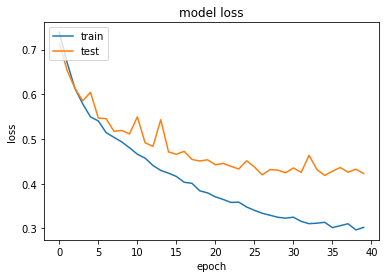

In [467]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

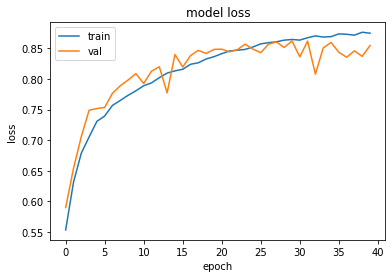

In [468]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [593]:
# Test the model
results = model.evaluate([X_test1, X_test2], Y_test, batch_size=16)
print('test loss, test acc: ', results)

5000/5000 [==============================] - 281s 56ms/sample - loss: 0.2862 - accuracy: 0.8956
test loss, test acc:  [0.2862263293027878, 0.8956]


In [594]:
# Set the model's name
model_name = '0.1.3.3_Softmax-LSTM-128_batch_40_epochs'

In [595]:
# Save the model
save_model(model, model_name)

## Manual Testing
Converts titles into embeddings arrays and allow the model to make a prediction

In [396]:
model.load_weights('models/' + model_name + '.h5')

In [620]:
title_one = 'ASUS VivoBook 15 Thin and Light Laptop, 15.6" FHD Display, Intel i5-1035G1 CPU, 8 GB RAM, 256 GB SSD + 1 TB HDD, Backlit Keyboard, Fingerprint, Windows 10, Slate Gray, F512JA-NH56'
title_two = 'ASUS Vivobook Laptop, 15.6” Full HD Screen, AMD Ryzen 5-3500U Processor up to 3.7GHz, 8GB RAM, 1TB PCIe SSD, Webcam, WiFi, Bluetooth, Online Class/Meeting Ready, Win 10 Home, Silver, KKE Mousepad'
title_one = 'hp'
title_two = 'lenovo'
title_one_arr = [' '] * MAX_LEN
title_two_arr = [' '] * MAX_LEN
title_one = remove_stop_words(title_one.lower())
title_two = remove_stop_words(title_two.lower())

for idx, x in enumerate(title_one.split(' ')):
    title_one_arr[idx] = x

for idx, x in enumerate(title_two.split(' ')):
    title_two_arr[idx] = x

title_one_arr = np.array(title_one_arr).reshape(1, 45).astype('<U22')
title_two_arr = np.array(title_two_arr).reshape(1, 45).astype('<U22')
print(title_two_arr)

[['lenovo' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' '
  ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' '
  ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']]


In [621]:
model.predict(x=[title_one_arr, title_two_arr])

array([[0.7301711 , 0.26982892]], dtype=float32)